In [2]:
# imports pytorch
import torch

In [3]:
import time
import copy
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import os
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image as Img
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import numpy as np
import torch.backends
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
torch.backends.cudnn.enabled = False
#CUDA_LAUNCH_BLOCKING=1.

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# 1. Exploracion y division de los set
- Se divide previamente los set de test y train 
- Posible Overfit por usar todas la imagenes en train

In [8]:
# Se particionan lo set en train test val (80 - 20)
# Posible overfit por usar 
drive = r"./data/"
archivo_train = drive+r"train.csv"
archivo_test = drive+r"test.csv"
dir_imagenes = drive+r"all_imgs"

In [9]:
dataset = pd.read_csv(archivo_test, index_col=0)

In [10]:
dataset[:1]

,path_img,label
idx_test,,
0,all_imgs/ec4c75ba-e064-4ed0-a7b1-3ed899424110....,6


#### La distribucion de labels esta balanceada no hay que adaptar nada

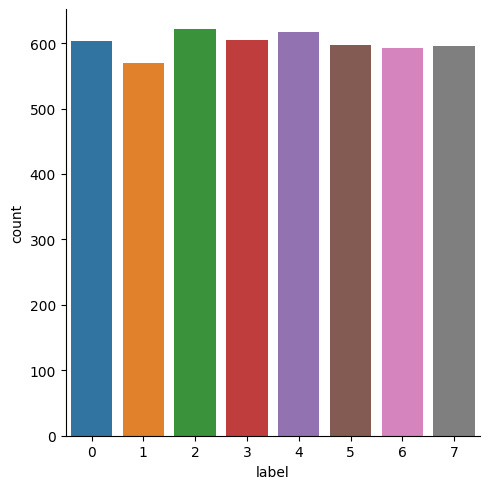

In [16]:
sns.catplot(data=dataset, x="label", kind="count", )

In [17]:
torch.manual_seed(101)

# 2. Clase del dataset para gestionar los datos
- Inicialmente se unen categorias para mejorar la precision sin transfer learning
- Los bocatas, hamburguesas y perritos bajaban la precision considerablemente por separado
- Con transfer learnin deja de ser necesario

In [18]:
class ComidasDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=0)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Img.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        '''
        # union de bocata 6 - burger 0
        if label == 6:
            label = 0
        
        # union de hot dog 4 - patata 7
        if label == 7:
            label = 4
        '''
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# 3. Data Augmentation
- Se prueban 2 tipos
- Se elige el standard CIFAR10 por ser utilizado en imagenes similares con buenos resultados
- Para test NO SE DEBEN HACER TRANSFORMACIONES
- Se redimensionan todas las imagens a 300x300, que es aproximadamente la moda. Los outliers son pocos asi que ignoramos las resoluciones muy altas o muy bajas

In [19]:
transform_train = transforms.Compose([
    transforms.Resize(size=(300,300)),
    transforms.ColorJitter(brightness=.5, hue=.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])

transform_pol = transforms.Compose([
    transforms.Resize(size=(300,300)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(size=(300,300)),
    transforms.ToTensor(),
])

In [20]:
dat_train = ComidasDataset(archivo_train, drive, transform=transform_pol )
dat_test = ComidasDataset(archivo_test, drive, transform=transform_test )

In [21]:
train = iter(dat_train)

0


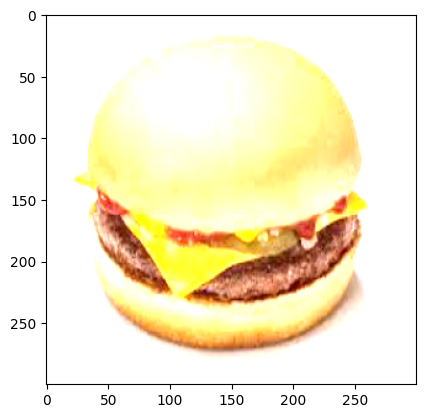

In [22]:
img, y = next(train)
plt.imshow(img.permute(1, 2, 0))
print(y)

In [23]:
""" Muy importante:
    Aqui se decide el batch size, que despues se incluye en la capa lineal
"""
train_dataloader = DataLoader(dat_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(dat_test, batch_size=100, shuffle=True)

# 4. Red neuronal
- Se elige densenet121, ya esta implementada en pytorch y da 90+ de acc en kaggle con datos similares. No nos complicamos
- El dataset preentrenado tiene muchas mas clases, por seguridad no congelamos las capas conv
- Optimizador adam
- Scheduling de lr, se reduce a la mitad cada 5 epoch, es suficiente
- Funcion de perdidad de entropia cruzada, aparenetemente la mejor para clasificacion, se usa en todos los demas trabajos

In [24]:
def CNN_Model(pretrained=False):
    class_names = ["Burger","Pollo","Donut","Fries","HotDog","Pizza","Bocata","Patata"]
    model = models.densenet121(pretrained=pretrained) 
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(class_names))
    device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device) 
    return model

In [25]:
model = CNN_Model(pretrained=True)

In [20]:
#PATH = drive+r"model_14marzo_parcial.pth"
#model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [22]:
# model.load_state_dict(torch.load(drive+f"model_13896134932304.pth"))

In [23]:
from torch.optim import Adam, lr_scheduler

learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # Learning Scheduler

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6962056


In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                    
            if phase == 'train':
                scheduler.step()
                print("Learnin rate =",optimizer.param_groups[0]["lr"])

            # Estaba 1 mas a al der
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
#model.load_state_dict(torch.load(drive+f"model_13marzo_final.pth"))
dataloaders = {"train":train_dataloader, "val":test_dataloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
base_model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
Learnin rate = 0.1
train Loss: 2.7417 | train Accuracy: 0.0537
val Loss: 2310110.1315 | val Accuracy: 0.1348 | Kappa Score: 0.0090
Val loss Decreased from inf to 2310110.1315 
Saving Weights... 

Epoch 2/100
----------
Learnin rate = 0.1
train Loss: 0.9015 | train Accuracy: 0.0670
val Loss: 3.3399 | val Accuracy: 0.1752 | Kappa Score: 0.0569
Val loss Decreased from 2310110.1315 to 3.3399 
Saving Weights... 

Epoch 3/100
----------
Learnin rate = 0.1
train Loss: 0.8522 | train Accuracy: 0.0944
val Loss: 2.0423 | val Accuracy: 0.2242 | Kappa Score: 0.1106
Val loss Decreased from 3.3399 to 2.0423 
Saving Weights... 

Epoch 4/100
----------
Learnin rate = 0.1
train Loss: 0.8174 | train Accuracy: 0.1115
val Loss: 2.2188 | val Accuracy: 0.2000 | Kappa Score: 0.0834

Epoch 5/100
----------
Learnin rate = 0.05
train Loss: 0.7977 | train Accuracy: 0.1207
val Loss: 1.5950 | val Accuracy: 0.4200 | Kappa Score: 0.3343

Epoch 14/100
----------
Learnin rate = 0.025
train Loss:

# 5. Guardamos el modelo con la menor perdida
- Se comprueba la matriz de confusion
- Se exporta el modelo al completo

In [ ]:
torch.save(base_model.state_dict(), drive+f"model_14marzo_parcial__.pth")

In [26]:
PATH = drive+r"model_14marzo_parcial__.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [27]:
import gc
gc.collect() # Python thing

9

In [28]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        y = Variable(labels.to(device))
        
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        #labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [29]:
# Calcular la matriz de confusión
labels = ["Burger","Pollo","Donut","Fries","HotDog-papta","Pizza","Bocata","Patata"]
labels_parcial = ["Burger-bocata","Pollo","Donut","Fries","HotDog-papta","Pizza"]
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[580   0   5   3   2   0  10   3]
 [  5 503   6  13   3   5  21  13]
 [  0   2 579   5   6   5  12  12]
 [  0  13   6 548  14  11   3   9]
 [  1   4   7  14 560  12  10   9]
 [  0   4   5   7  12 541  13  15]
 [ 22  16   6  11   3  13 509  13]
 [  1  10   6   2   9  12  12 544]]


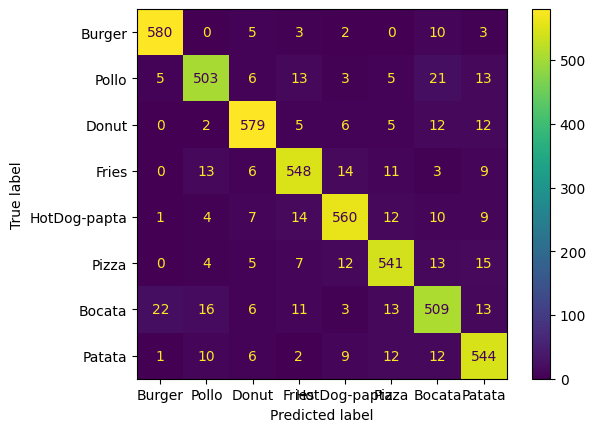

In [31]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot()

plt.show()

In [104]:
confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

In [1]:
print(classification_report(y_true, y_pred,target_names=labels_parcial))

NameError: name 'classification_report' is not defined

In [ ]:
#Guarda el modelo  grande
PATH = drive+r"ModeloFinalGrande_trans.pt"
torch.save(model, PATH)